In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl


import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve, cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve, classification_report
from sklearn.utils import shuffle
from sklearn.svm import SVC
#from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
#from eli5.sklearn import PermutationImportance
#import eli5
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
import pickle
import warnings
import numpy as np
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")

## Features

* enrollee_id : Unique ID for enrollee
* city: City code
* citydevelopmentindex: Developement index of the city (scaled)
* gender: Gender of enrolee
* relevent_experience: Relevent experience of enrolee
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of enrolee
* major_discipline :Education major discipline of enrolee
* experience: Enrolee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change



# Training Data

In [2]:
raw_train = pd.read_csv('aug_train.csv')
raw_test = pd.read_csv('aug_test.csv')
# sub = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/sample_submission.csv')

In [3]:
raw_train.head()

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

In [4]:
raw_test.head()

enrollee_id      city  city_development_index  gender  \
0        32403   city_41                   0.827    Male   
1         9858  city_103                   0.920  Female   
2        31806   city_21                   0.624    Male   
3        27385   city_13                   0.827    Male   
4        27724  city_103                   0.920    Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience    Full time course        Graduate   
1  Has relevent experience       no_enrollment        Graduate   
2   No relevent experience       no_enrollment     High School   
3  Has relevent experience       no_enrollment         Masters   
4  Has relevent experience       no_enrollment        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM          9          <10          NaN            1   
1             STEM          5          NaN      Pvt Ltd            1   
2              NaN         <1          NaN      Pvt Ltd        never   
3             STEM         11        10/49      Pvt Ltd            1   
4             STEM        >20       10000+      Pvt Ltd           >4   

   training_hours  
0              21  
1              98  
2              15  
3              39  
4              72

Let's check maches of ID in train and test data.

In [5]:
set(raw_train.enrollee_id)&set(set(raw_test.enrollee_id))

set()

# Target

* 0 – Not looking for job change, 
* 1 – Looking for a job change

We have a big imbalance in data.  

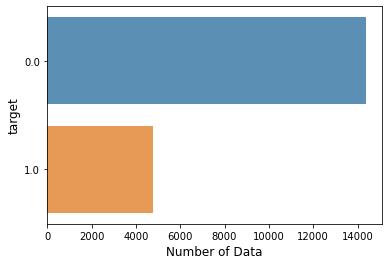

In [6]:
graf = sns.countplot(y="target", data=raw_train, alpha=0.8)
plt.xlabel('Number of Data', fontsize=12)
plt.ylabel('target', fontsize=12)

plt.show()

# Bar plots

I think that having relevant experience is important if you want to change jobs. Let/s look on the data in this view.

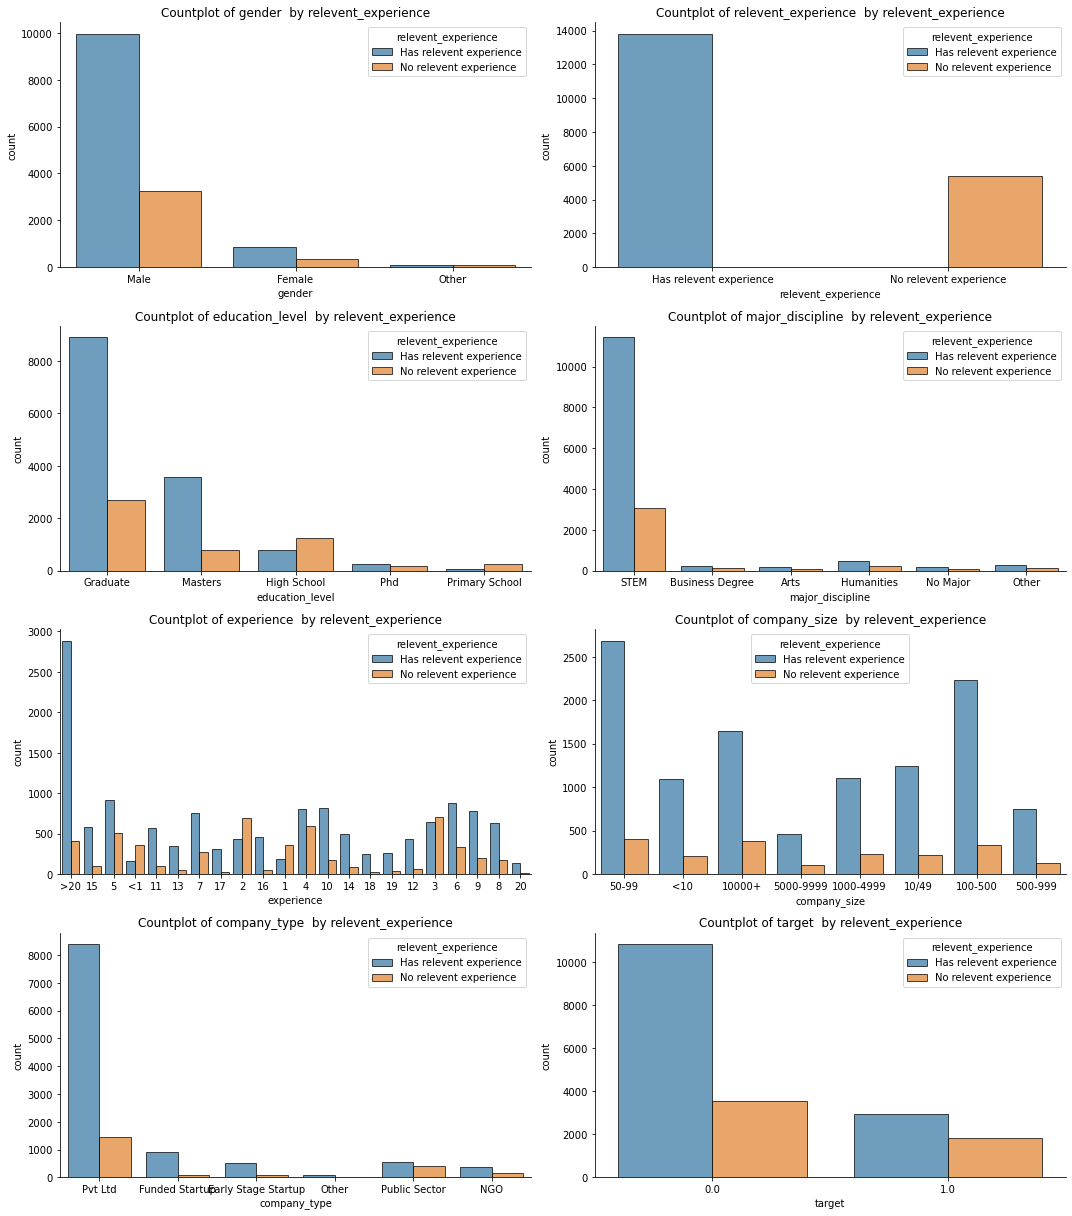

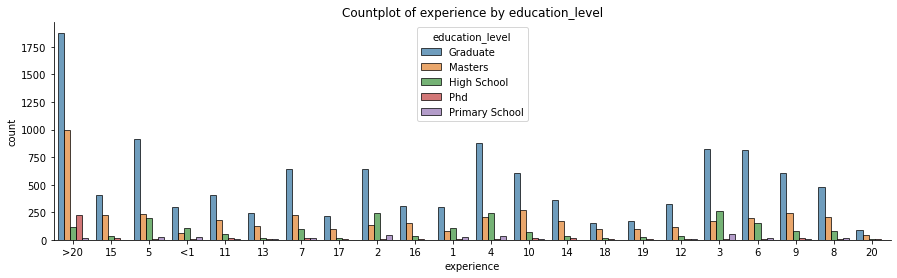

In [7]:
plt.figure(figsize=[15,17])
fft=["gender", "relevent_experience", "education_level", "major_discipline", "experience", "company_size", "company_type", "target"]
n=1
for f in fft:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='relevent_experience', edgecolor="black", alpha=0.7, data=raw_train)
    sns.despine()
    plt.title("Countplot of {}  by relevent_experience".format(f))
    n=n+1
plt.tight_layout()
plt.show()


    
plt.figure(figsize=[15,4])
sns.countplot(x='experience', hue='education_level',edgecolor="black", alpha=0.7, data=raw_train)
sns.despine()
plt.title("Countplot of experience by education_level")
plt.show()

I note that these are the largest groups:
- men
- students
- STEM specialization, maybe people have more choice
- current company type PVT LTD
- over 20 years of experience

# Education level

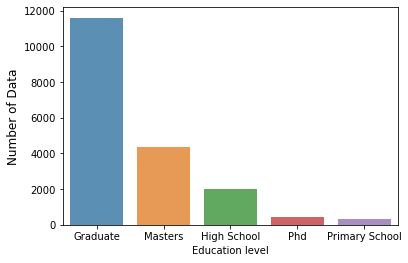

In [8]:
education_graf = sns.countplot(x='education_level', alpha=0.8, data=raw_train)
plt.ylabel("Number of Data", fontsize=12)
plt.xlabel("Education level", fontsize=10)
plt.show()

# City development index

<img src="https://www.researchgate.net/profile/Lubna_Hasan/publication/24115086/figure/tbl4/AS:668624478019607@1536423906970/Calculation-of-CDI-by-UN-HABITAT-GUIP-Index-Formula.png" width="600">

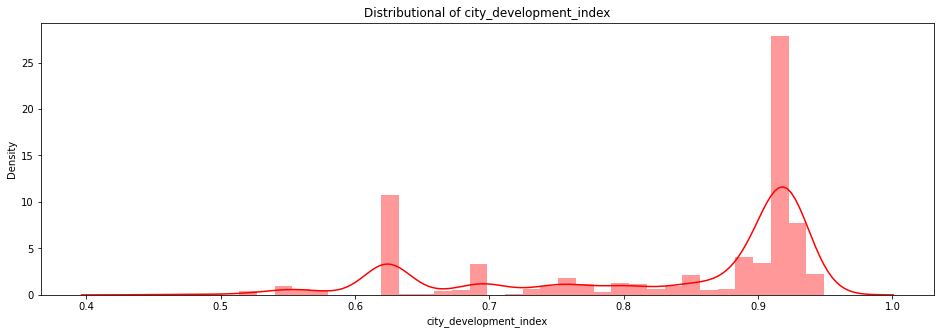

In [9]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

cd = raw_train['city_development_index'].value_counts().reset_index()
cd.columns = [
    'city_development_index', 
    'count'
]
cd['city_development_index'] = cd['city_development_index'].astype(str) + '-'
cd = cd.sort_values(['count']).tail(50)

fig = px.bar(
    cd, 
    x='count', 
    y='city_development_index', 
    orientation='h', 
    title='Count: City development index', 
    width=1000,
    height=900 
)

fig.show()

f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.distplot(raw_train["city_development_index"], color="red",ax = axes)
plt.title("Distributional of city_development_index")
plt.show()

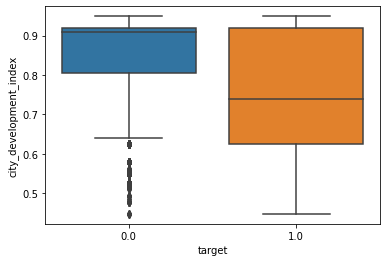

In [10]:
sns.boxplot(x='target', y='city_development_index', data=raw_train)
plt.show()

The probability of a new job search increases when **city development index** is lower.

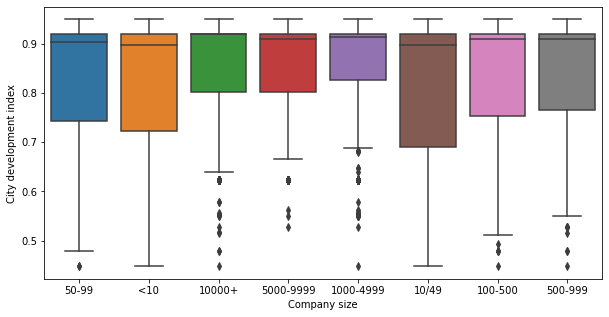

In [11]:
plt.figure(figsize=[10, 5])
sns.boxplot(x='company_size', y='city_development_index', data=raw_train)
plt.xlabel('Company size')
plt.ylabel('City development index')
plt.show()

Big companies usually are placed in cities with a high rating of **city development index**.

# Training hours

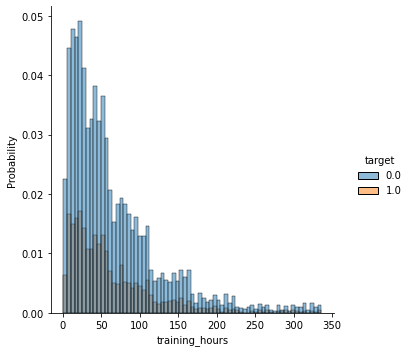

In [12]:
sns.displot(x='training_hours',
            hue='target',
            data=raw_train,
            stat="probability")
plt.show()

**Training hours** don't provide new correlations from the data.

# Feature Engineering

There is a point that young students are inclined to look for a new job, but we do not have a person's age in the dataset, but we can potentially designate it using several features.

In [13]:
raw_data_age = raw_train[['enrollee_id', 'education_level', 'experience', 'last_new_job']]\
    .groupby(['education_level', 'experience', 'last_new_job']).sum('enrollee_id').reset_index()

In [14]:
raw_data_age[:5]

education_level experience last_new_job  enrollee_id
0        Graduate          1            1      3631352
1        Graduate          1        never      1431833
2        Graduate         10            1      4285362
3        Graduate         10            2      1805169
4        Graduate         10            3       733292

People with PhD and extensive experience cannot be in a group under 20 years old because this  PhD and Master's degree are not for young specialists.

Let's take an approximate time frame for age categories, if there is more data, it can be made more accurate than focusing on education and experience.

- young < 20 y.o.
- adult - 20-40 y.o.
- middle - 40-60 y.o.
- old - >60 y.o.

In [15]:
def get_age_category(x, y):
    if ((x in ['1', '2', '3', '4', '5', '6', '<1', '7', '8']) &
            ((y in ['Phd']) | (y in ['Masters']) | (y in ['Graduate']))):
        return 'Adult'
    elif ((x in ['1', '2', '3', '<1']) & (y != 'Phd') & (y != 'Masters') &
          (y != 'Graduate')):
        return 'Young'
    elif (x in ['9', '10', '11', '12', '13', '14', '15']):
        return 'Middle'
    elif (x in ['16', '17', '18', '19', '20', '>20']):
        return 'Old'

In [16]:
raw_train['age'] = raw_train.apply(lambda row: get_age_category(row['experience'], row['education_level']), axis=1)

In [17]:
raw_train.age.value_counts()

Adult     7373
Old       4868
Middle    4794
Young     1034
Name: age, dtype: int64

# Correlation in Data

Here I try to measure correlation in data using Correlation coefficients.

Correlation coefficientsare used to measure how strong a relationship is between two variables.Correlation coefficient formulas are used to find how strong a relationship is between data. The formulas return a value between -1 and 1, where:
 
* 1 indicates a strong positive relationship.
* -1 indicates a strong negative relationship.
* A result of zero indicates no relationship at all.

In [18]:
corr=raw_train.corr()["target"]
corr[np.argsort(corr, axis=0)[:-1]]

city_development_index   -0.341665
training_hours           -0.021577
enrollee_id               0.049475
Name: target, dtype: float64

Below we are plotting heatmap showing nullity correlation between various columns of dataset.

The nullity correlation ranges from -1 to 1.

* -1 - Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
* 0 - No correlation represents that variables values present or absent do not have any effect on one another.
* 1 - Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present.

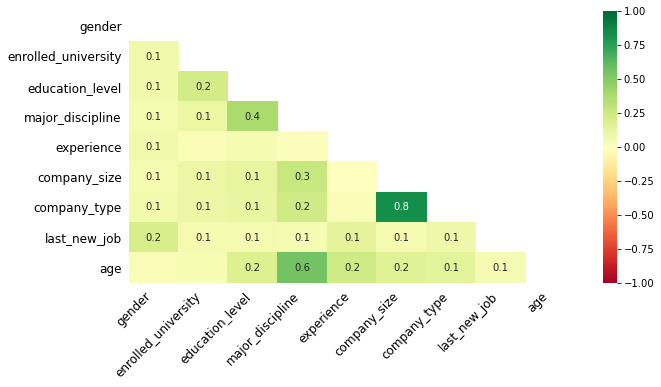

In [19]:
import missingno
missingno.heatmap(raw_train, cmap="RdYlGn", figsize=(10,5), fontsize=12);

# Prerpocessing

Here I find unique names of columns of objects and create functions that convert all values into numbers.

In [20]:
cols_object = list(raw_train.dtypes[raw_train.dtypes =='object'].index)
t = 0
for i in cols_object:
    cols_object[t] = raw_train[i].unique()  
    cols_object[t] = [i for i in cols_object[t] if i is not np.nan]
    t = t+1
    
cols_object[-1] = [i for i in cols_object[-1] if i is not  None]

In [21]:
print(cols_object)

[['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176', 'city_160', 'city_46', 'city_61', 'city_114', 'city_13', 'city_159', 'city_102', 'city_67', 'city_100', 'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83', 'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93', 'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19', 'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97', 'city_50', 'city_138', 'city_82', 'city_157', 'city_89', 'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59', 'city_165', 'city_145', 'city_142', 'city_26', 'city_12', 'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149', 'city_10', 'city_45', 'city_80', 'city_128', 'city_158', 'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78', 'city_109', 'city_24', 'city_134', 'city_48', 'city_144', 'city_91', 'city_146', 'city_133', 'city_126', 'city_118', 'city_9', 'city_167', 'city_27', 'city_84', 'city_54', 'city_

In [22]:
cols = list(raw_train.dtypes[raw_train.dtypes =='object'].index)

print(cols)

['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'age']


In [23]:
names = {
    'city': 0, 
    'gender': 1, 
    'relevent_experience': 2, 
    'enrolled_university': 3, 
    'education_level': 4, 
    'major_discipline': 5, 
    'experience': 6, 
    'company_size': 7, 
    'company_type': 8, 
    'last_new_job': 9, 
    'age': 10
}

_dict = {key: {cols_object[names[key]][i]: i for i in range(len(cols_object[names[key]]))} for key in cols}

for key in cols:
    raw_train[key] = raw_train[key].map(_dict[key]) 

In [24]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int64  
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  float64
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     18772 non-null  float64
 6   education_level         18698 non-null  float64
 7   major_discipline        16345 non-null  float64
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  float64
 10  company_type            13018 non-null  float64
 11  last_new_job            18735 non-null  float64
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
 14  age                     18069 non-null

# Fill missing values

In [25]:
print("Any missing sample in training set:",raw_train.isnull().values.any())

Any missing sample in training set: True


In [26]:
raw_train.isna().mean()[raw_train.isna().mean() > 0] * 100

gender                 23.530640
enrolled_university     2.014824
education_level         2.401086
major_discipline       14.683161
experience              0.339284
company_size           30.994885
company_type           32.049274
last_new_job            2.207955
age                     5.684309
dtype: float64

In [27]:
missing_cols = raw_train.columns[raw_train.isna().any()].tolist()

missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'age']

I choose to use a k-nearest neighbour method for missing values.To do this, divide the dataframe into columns with and without missing values.

In [28]:
#dataframe having features with missing values
df_missing = raw_train[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing = raw_train.drop(missing_cols, axis = 1)

In [29]:
knn = KNNImputer(n_neighbors = 3)
X = np.round(knn.fit_transform(df_missing))
df_missing = pd.DataFrame(X, columns = df_missing.columns)

In [30]:
#Let's join both dataframes
train = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

In [31]:
train

enrollee_id  gender  enrolled_university  education_level  \
0           8949.0     0.0                  0.0              0.0   
1          29725.0     0.0                  0.0              0.0   
2          11561.0     0.0                  1.0              0.0   
3          33241.0     1.0                  1.0              0.0   
4            666.0     0.0                  0.0              1.0   
...            ...     ...                  ...              ...   
19153       7386.0     0.0                  0.0              0.0   
19154      31398.0     0.0                  0.0              0.0   
19155      24576.0     0.0                  0.0              0.0   
19156       5756.0     0.0                  0.0              2.0   
19157      23834.0     0.0                  0.0              4.0   

       major_discipline  experience  company_size  company_type  last_new_job  \
0                   0.0         0.0           2.0           0.0           0.0   
1                   0.0         1.0           0.0           0.0           1.0   
2                   0.0         2.0           3.0           0.0           2.0   
3                   1.0         3.0           2.0           0.0           2.0   
4                   0.0         0.0           0.0           1.0           3.0   
...                 ...         ...           ...           ...           ...   
19153               3.0        13.0           4.0           0.0           0.0   
19154               0.0        13.0           3.0           0.0           3.0   
19155               0.0         0.0           0.0           0.0           3.0   
19156               0.0         3.0           7.0           0.0           5.0   
19157               0.0         8.0           4.0           2.0           0.0   

       age  city  city_development_index  relevent_experience  training_hours  \
0      0.0     0                   0.920                    0              36   
1      1.0     1                   0.776                    1              47   
2      2.0     2                   0.624                    1              83   
3      2.0     3                   0.789                    1              52   
4      0.0     4                   0.767                    0               8   
...    ...   ...                     ...                  ...             ...   
19153  1.0    35                   0.878                    1              42   
19154  1.0     0                   0.920                    0              52   
19155  0.0     0                   0.920                    0              44   
19156  3.0    33                   0.802                    0              97   
19157  3.0    13                   0.855                    1             127   

       target  
0         1.0  
1         0.0  
2         0.0  
3         1.0  
4         0.0  
...       ...  
19153     1.0  
19154     1.0  
19155     0.0  
19156     0.0  
19157     0.0  

[19158 rows x 15 columns]

# Testing Data

In [32]:
raw_test.head()

enrollee_id      city  city_development_index  gender  \
0        32403   city_41                   0.827    Male   
1         9858  city_103                   0.920  Female   
2        31806   city_21                   0.624    Male   
3        27385   city_13                   0.827    Male   
4        27724  city_103                   0.920    Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience    Full time course        Graduate   
1  Has relevent experience       no_enrollment        Graduate   
2   No relevent experience       no_enrollment     High School   
3  Has relevent experience       no_enrollment         Masters   
4  Has relevent experience       no_enrollment        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM          9          <10          NaN            1   
1             STEM          5          NaN      Pvt Ltd            1   
2              NaN         <1          NaN      Pvt Ltd        never   
3             STEM         11        10/49      Pvt Ltd            1   
4             STEM        >20       10000+      Pvt Ltd           >4   

   training_hours  
0              21  
1              98  
2              15  
3              39  
4              72

In [33]:
raw_test['age'] = raw_test.apply(lambda row: get_age_category(row['experience'], row['education_level']), axis=1)

In [34]:
raw_test.age.value_counts()

Adult     819
Old       561
Middle    515
Young     113
Name: age, dtype: int64

In [35]:
for key in cols:
    raw_test[key] = raw_test[key].map(_dict[key]) 


raw_test

enrollee_id  city  city_development_index  gender  relevent_experience  \
0           32403    24                   0.827     0.0                    0   
1            9858     0                   0.920     1.0                    0   
2           31806     2                   0.624     0.0                    1   
3           27385    10                   0.827     0.0                    0   
4           27724     0                   0.920     0.0                    0   
...           ...   ...                     ...     ...                  ...   
2124         1289     0                   0.920     0.0                    1   
2125          195    36                   0.897     0.0                    0   
2126        31762    14                   0.887     0.0                    1   
2127         7873    12                   0.804     0.0                    0   
2128        12215    12                   0.804     0.0                    0   

      enrolled_university  education_level  major_discipline  experience  \
0                     1.0              0.0               0.0        19.0   
1                     0.0              0.0               0.0         2.0   
2                     0.0              2.0               NaN         3.0   
3                     0.0              1.0               0.0         4.0   
4                     0.0              0.0               0.0         0.0   
...                   ...              ...               ...         ...   
2124                  0.0              0.0               3.0         9.0   
2125                  0.0              1.0               0.0        14.0   
2126                  0.0              4.0               NaN        17.0   
2127                  1.0              2.0               NaN         6.0   
2128                  0.0              1.0               0.0         1.0   

      company_size  company_type  last_new_job  training_hours  age  
0              1.0           NaN           0.0              21  1.0  
1              NaN           0.0           0.0              98  2.0  
2              NaN           0.0           2.0              15  3.0  
3              5.0           0.0           0.0              39  1.0  
4              2.0           0.0           1.0              72  0.0  
...            ...           ...           ...             ...  ...  
2124           NaN           4.0           3.0              15  0.0  
2125           NaN           NaN           5.0              30  0.0  
2126           NaN           0.0           2.0              18  3.0  
2127           6.0           4.0           0.0              84  NaN  
2128           2.0           0.0           5.0              11  1.0  

[2129 rows x 14 columns]

In [36]:
print("Any missing sample in test set:",raw_test.isnull().values.any(), "\n")

Any missing sample in test set: True 



In [37]:
raw_test.isna().mean()[raw_test.isna().mean() > 0] * 100

gender                 23.860968
enrolled_university     1.456083
education_level         2.442461
major_discipline       14.654767
experience              0.234852
company_size           29.215594
company_type           29.779239
last_new_job            1.878816
age                     5.683419
dtype: float64

I choose to use KNN method for defining missing values.

In [38]:
#dataframe having features with missing values
df_missing_test = raw_test[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing_test = raw_test.drop(missing_cols, axis = 1)

In [39]:
knn = KNNImputer(n_neighbors = 3)
X = np.round(knn.fit_transform(df_missing_test))
df_missing_test = pd.DataFrame(X, columns = df_missing_test.columns)

In [40]:
test = pd.merge(df_missing_test, df_non_missing_test, on = 'enrollee_id')

In [41]:
print("Any missing sample in train set:",train.isnull().values.any(), "\n")
print("Any missing sample in test set:",test.isnull().values.any(), "\n")


Any missing sample in train set: False 

Any missing sample in test set: False 



# Model

In [42]:
from sklearn.model_selection import train_test_split
y = train['target']
X = train.drop(columns=['target', 'enrollee_id', 'city_development_index', 'training_hours'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=9)


In [43]:
from xgboost import XGBClassifier
clf_XGB = XGBClassifier()

clf_XGB.fit(X_train, y_train, eval_metric='logloss')

y_train_pred = clf_XGB.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf_XGB.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)


print('Model params:')
print(clf_XGB.get_params())
print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Model params:
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Train AUC Score 0.8926461059494321
Test AUC Score 0.762595090335819


In [44]:
def get_scores(report_df, model, X_val, y_val, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_val,
                                      model.predict_proba(X_val)[:, 1])
    report['F1'] = f1_score(y_val, model.predict(X_val))
    report['precision_0'] = precision_score(
        y_val, model.predict(X_val), pos_label=0)
    report['precision_1'] = precision_score(
        y_val, model.predict(X_val), pos_label=1)
    report['recall_0'] = recall_score(
        y_val, model.predict(X_val), pos_label=0)
    report['recall_1'] = recall_score(
        y_val, model.predict(X_val), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df


In [45]:
df_report = pd.DataFrame()
df_report = get_scores(df_report, clf_XGB, X_val,
                       y_val, 'XGBClassifier KNN')

In [46]:
df_report

ROC-AUC        F1  precision_0  precision_1  recall_0  \
XGBClassifier KNN  0.762595  0.490895     0.812262     0.609037  0.906132   

                   recall_1  
XGBClassifier KNN  0.411141

As we can see model is overfitting the data, we can do various things to resolve this problem like we can increase data set size in balanced manner and we can also tune hyperparameters of model.

Let's plot AUC Curve.

In [47]:
def plot_auc_curve(fpr, tpr, auc):
    plt.figure(figsize = (16,6))
    plt.plot(fpr,tpr,'b+',linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Postive Rate')
    plt.title(f'ROC Curve Having AUC = {auc}')

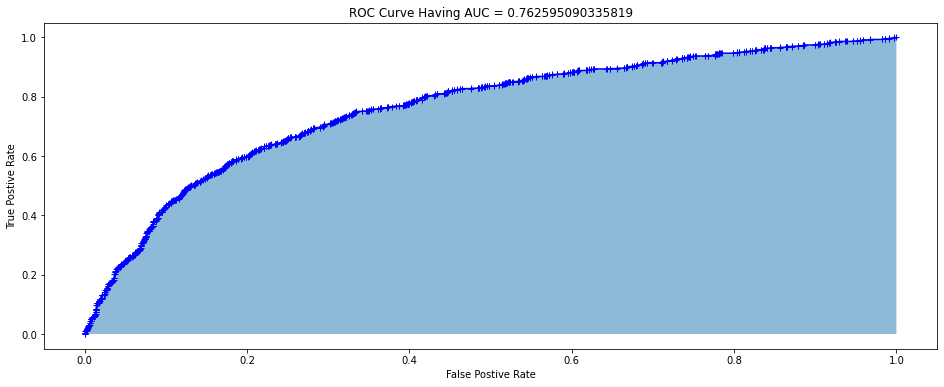

In [48]:
plot_auc_curve(fpr, tpr, auc_test)

# Learning curve

It is a tool to find out how much a machine model benefits from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, it will not benefit much from more training data.

In [49]:
# funtion to plot learning curves

def plot_learning_cuve(model, X, Y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(200,len(x_train),200):
        
        model.fit(x_train.iloc[:m,:], y_train[:m], eval_metric='logloss', verbose=False)
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')



    plt.show()

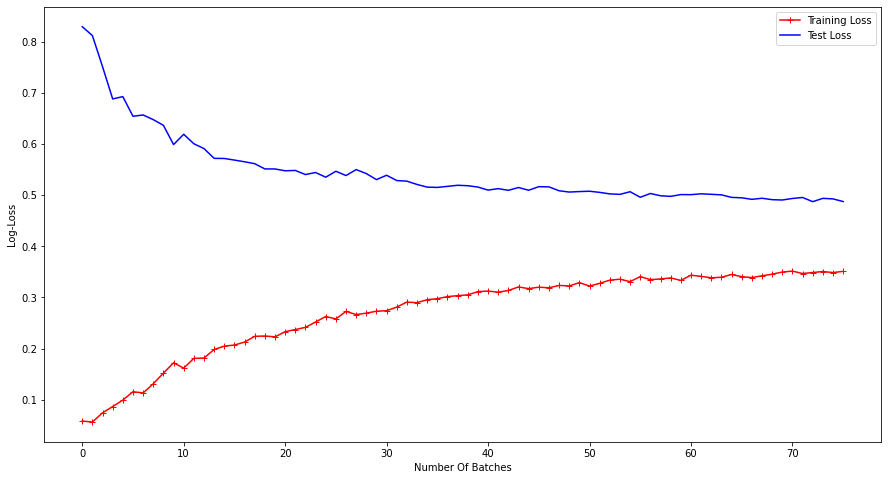

In [50]:
plot_learning_cuve(XGBClassifier(), X, y)

There is a high variance problem and I need to make more training data.

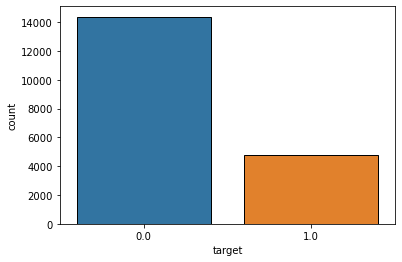

In [51]:
sns.countplot(y, edgecolor = 'black')
plt.show()

Let's try to increase data in balanced manner using Synthetic Minority Oversampling Technique (SMOTE)

# Oversampling (SMOTE)

In [52]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


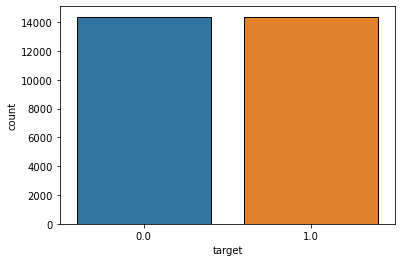

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 402)
X_smote, y_smote = smote.fit_resample(X, y)


sns.countplot(y_smote, edgecolor = 'black')
plt.show()

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size = 0.2 ,random_state = 42)

clf_XGB_smote = XGBClassifier()

clf_XGB_smote.fit(X_train, y_train, eval_metric='logloss')

y_train_pred = clf_XGB_smote.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf_XGB_smote.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)


print('Model params:')
print(clf_XGB_smote.get_params())
print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Model params:
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Train AUC Score 0.9561158516977865
Test AUC Score 0.9162515838289674


In [55]:
df_report = get_scores(df_report, clf_XGB_smote, X_val,
                       y_val, 'XGBClassifier KNN(SMOTE)')


In [56]:
df_report

ROC-AUC        F1  precision_0  precision_1  \
XGBClassifier KNN         0.762595  0.490895     0.812262     0.609037   
XGBClassifier KNN(SMOTE)  0.916252  0.836668     0.816033     0.877193   

                          recall_0  recall_1  
XGBClassifier KNN         0.906132  0.411141  
XGBClassifier KNN(SMOTE)  0.888078  0.799722

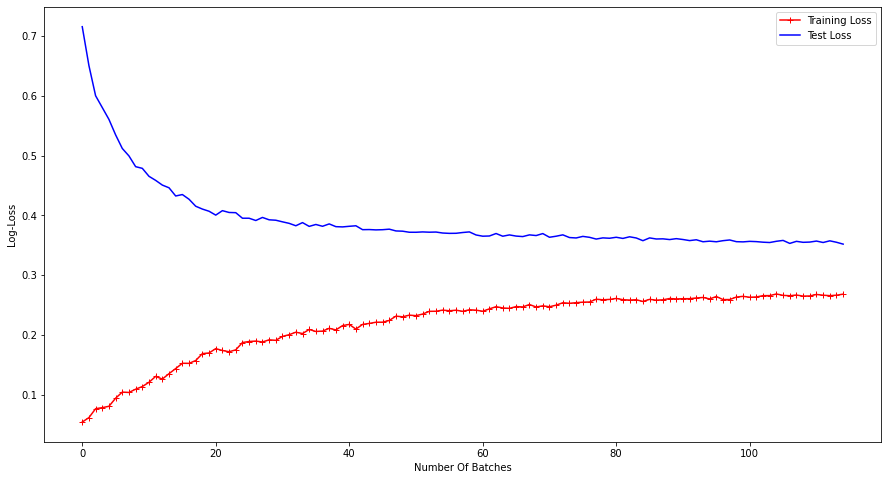

In [57]:
plot_learning_cuve(XGBClassifier(), X_smote, y_smote)

### Comparing with CatBoostClassifier

In [58]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, MetricVisualizer

X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size = 0.2 ,random_state = 42)

CB_CLASS = CatBoostClassifier(iterations=200,
                           learning_rate=0.1,
                           depth=8,loss_function='Logloss',
                             custom_loss=['AUC', 'Accuracy'],
                             )

CB_CLASS.fit(X_train, y_train,
            eval_set=(X_val, y_val),
            verbose=False)

y_train_pred = CB_CLASS.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = CB_CLASS.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print('Model is fitted:' + str(CB_CLASS.is_fitted()))
print('Model params:')
print(CB_CLASS.get_params())
print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Model is fitted:True
Model params:
{'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'loss_function': 'Logloss', 'custom_loss': ['AUC', 'Accuracy']}
Train AUC Score 0.9485642542789946
Test AUC Score 0.9157669478763759


In [59]:
df_report = get_scores(df_report, CB_CLASS, X_val,
                       y_val, 'CB_CLASS KNN(SMOTE)')

df_report

ROC-AUC        F1  precision_0  precision_1  \
XGBClassifier KNN         0.762595  0.490895     0.812262     0.609037   
XGBClassifier KNN(SMOTE)  0.916252  0.836668     0.816033     0.877193   
CB_CLASS KNN(SMOTE)       0.915767  0.835104     0.811731     0.882649   

                          recall_0  recall_1  
XGBClassifier KNN         0.906132  0.411141  
XGBClassifier KNN(SMOTE)  0.888078  0.799722  
CB_CLASS KNN(SMOTE)       0.894682  0.792420

In [60]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf_XGB_smote, X = X_train, y = y_train, verbose=False, cv = 5)
print("Accuracy:{:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

[15:43:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [61]:
print("Accuracy:{:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

Accuracy:84.23 %
Standard Deviation:0.28 %


In [62]:
df_report

ROC-AUC        F1  precision_0  precision_1  \
XGBClassifier KNN         0.762595  0.490895     0.812262     0.609037   
XGBClassifier KNN(SMOTE)  0.916252  0.836668     0.816033     0.877193   
CB_CLASS KNN(SMOTE)       0.915767  0.835104     0.811731     0.882649   

                          recall_0  recall_1  
XGBClassifier KNN         0.906132  0.411141  
XGBClassifier KNN(SMOTE)  0.888078  0.799722  
CB_CLASS KNN(SMOTE)       0.894682  0.792420

# Prediction

In [63]:
features =["city", "city_development_index", "gender", "relevent_experience", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "company_type", "last_new_job", "training_hours", "age"]
target = 'target'

In [64]:
#Make predictions using XGB
y_predict_XGB = clf_XGB_smote.predict(X_val)

y_predict_XGB

array([0., 0., 0., ..., 1., 1., 0.])

In [65]:
#Make predictions using CB
y_predict_CB = CB_CLASS.predict(X_val)

y_predict_CB

array([0., 0., 0., ..., 1., 1., 0.])

# Measure AUC


The AUC is an estimate of the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance. Reference : https://www.kdnuggets.com/2010/09/pub-is-auc-the-best-measure.html#:~:text=www.riceanalytics.com-,The%20area%20under%20the%20curve%20(AUC)%20that%20relates%20the%20hit,a%20randomly%20chosen%20negative%20instance.

In [66]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_predict_XGB)
metrics.auc(fpr, tpr)

0.8438998473819749

In [67]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_predict_CB)
metrics.auc(fpr, tpr)

0.8435509940959014

to be continued :)